## Predykcja zmiany za pomoca wytenowanego modelu (Statystyki)

#### Import bibliotek

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Funkcja `load_image`
Funkcja odpowiedzialna za wczytanie obrazu, jego dekodowanie, skalowanie do rozmiaru 224×224 oraz normalizację do [0, 1].

In [3]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  / 255.0
    return image

#### Wczytanie modelu i danych testowych

In [4]:
model = tf.keras.models.load_model("resnet50_best_model.h5", compile=False)

df_test = pd.read_csv("./data/processed/images_to_train/resnet/test.csv")
df_test = df_test[['path', 'risk_group']]
data = list(df_test.itertuples(index=False, name=None))
class_labels = ['Low Risk', 'High Risk']

#### Przetwarzanie danych i predykcje

In [ ]:
results = []

for path, true_label in data:
    image_input = tf.expand_dims(load_image(path), axis=0)
    pred = model.predict(image_input, verbose=0)
    predicted_class = class_labels[1] if pred[0][0] > 0.5 else class_labels[0]

    results.append({
        "path": path,
        "true_label": true_label,
        "predicted_label": predicted_class,
        "probability_high_risk": float(pred[0][0])
    })


#### Konwersja do DataFrame i zapis wyników

In [6]:
df_results = pd.DataFrame(results)
df_results.to_csv("predictions_results.csv", index=False)
df_results.head()

,path,true_label,predicted_label,probability_high_risk
0,data\processed\images_to_train\resnet\test\ISI...,Low Risk,Low Risk,0.401970
1,data\processed\images_to_train\resnet\test\ISI...,Low Risk,Low Risk,0.426848
2,data\processed\images_to_train\resnet\test\ISI...,Low Risk,Low Risk,0.250188
3,data\processed\images_to_train\resnet\test\ISI...,Low Risk,Low Risk,0.412577
4,data\processed\images_to_train\resnet\test\ISI...,Low Risk,Low Risk,0.137381


#### Obliczenie skuteczności dla każdej klasy

In [7]:
def calculate_accuracy(df, group_label):
    group_df = df[df['true_label'] == group_label]
    total = len(group_df)
    correct = (group_df['true_label'] == group_df['predicted_label']).sum()
    accuracy = correct / total * 100 if total > 0 else 0
    return accuracy, correct, total

low_risk_acc, low_risk_correct, low_risk_total = calculate_accuracy(df_results, "Low Risk")
high_risk_acc, high_risk_correct, high_risk_total = calculate_accuracy(df_results, "High Risk")

print(f"Low Risk accuracy: {low_risk_acc:.2f}% ({low_risk_correct}/{low_risk_total})")
print(f"High Risk accuracy: {high_risk_acc:.2f}% ({high_risk_correct}/{high_risk_total})")


Low Risk accuracy: 91.86% (734/799)
High Risk accuracy: 38.28% (80/209)


#### Macierz pomyłek (Confusion Matrix)

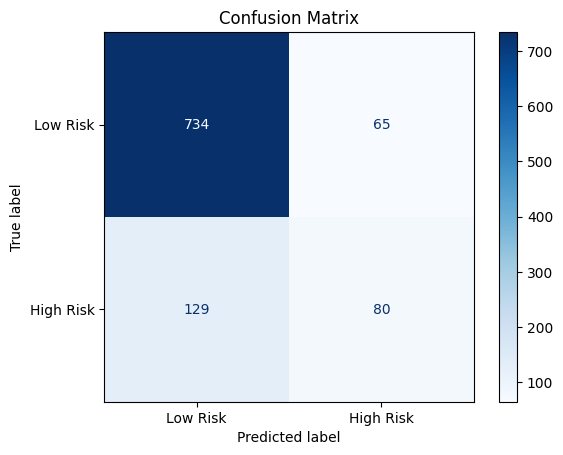

In [8]:
cm = confusion_matrix(df_results['true_label'], df_results['predicted_label'], labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
